In [1]:
import re
import collections
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import os
import random
from joint_stemmer_postagger import TurkishStemmerPOSTagger
from nltk.tokenize.casual import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from IPython.display import Markdown, display
import _pickle as pickle
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.manifold import TSNE
from networkx.algorithms import community
import pandas as pd
from IPython.display import HTML, display

c:\program files\python36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def printmd(string):
    """
    Print markdown strings
    """
    display(Markdown(string))

def asciify_txt(txt):
    """
    Convert non-ascii Turkish characters (ı, ş , ğ) to their ascii forms (i, s, g)
    :param txt: String variable tobe asciified
    :return: Asciified string
    """
    asciified = txt
    asciified = asciified.replace("ı", "i")
    asciified = asciified.replace("ü", "u")
    asciified = asciified.replace("ş", "s")
    asciified = asciified.replace("ö", "o")
    asciified = asciified.replace("ğ", "g")
    asciified = asciified.replace("ç", "c")
    asciified = asciified.replace("İ", "I")
    asciified = asciified.replace("Ü", "U")
    asciified = asciified.replace("Ş", "S")
    asciified = asciified.replace("Ö", "O")
    asciified = asciified.replace("Ğ", "G")
    asciified = asciified.replace("Ç", "C")
    return asciified

In [3]:
# READ TURKISH STOP WORDS FROM FILE
stop_words = []
with open("resources/nlp/turkish/stopwords.txt", "r", encoding="UTF-8") as f:
    for line in f:
        stop_words.append(line.strip())
ascified_stop_words = []
for stop_word in stop_words:
    ascified_stop_words.append(asciify_txt(stop_word))

In [4]:
# READ SEMEVAL RESTAURANT DATASET
# Preprocessing steps: 
# (1) Tokenization, 
# (2) Lowercase all characters
# (3) Stop word removal
# (4) Non-word removal (punctuations and numbers)
# (5) Naive rule based stemming for Turkish 
# (6) Asciificaiton

# FILE PATHS
raw_data_path = "resources/data/restaurant_sentence_level.txt"
preprocesed_data_path = "resources/data/restaurant_sentence_level_preprocessed.txt"

# Create tokenizer and stemmer objects
tokenizer = TweetTokenizer()
stemmer = TurkishStemmerPOSTagger.create_from_existed_model()

raw_reviews = []
preprocessed_reviews = []
first_level_labels = []
second_level_labels = []

# IF PREPROCESSED FILE IS CREATED BEFORE, USE IT TO READ DATASET
if os.path.isfile(preprocesed_data_path):
    with open(preprocesed_data_path, "r", encoding="UTF-8") as f:
        for line in f:
            splits = line.strip().split("\t")
            if len(splits) != 3:
                print("Error in line: {}".format(line))
            review = splits[0]
            raw_reviews.append(review)
            preprocessed_review = splits[1]
            preprocessed_reviews.append(preprocessed_review)
            labels = list(set(splits[2].split(" ")))
            first_level_labels.append([re.sub(r"#.*$", "", s) for s in labels])
            second_level_labels.append([re.sub(r"^.*#", "", s) for s in labels])
# OTHERWISE APPLY PREPROCESSING STEPS TO RAW DATA THEN SAVE IT FOR FURTHER USE
else:
    with open(preprocesed_data_path, "w", encoding="UTF-8") as w:
        with open(raw_data_path, "r", encoding="UTF-8") as f:
            for line in f:
                splits = line.strip().split("\t")
                # Check if review has a label
                if len(splits) == 2:
                    review = splits[0].strip()
                    review = re.sub("[\t\r\n ]+", " ", review)
                    raw_reviews.append(review)
                    review = review.lower()
                    tokens = tokenizer.tokenize(review)
                    tokens = [token for token in tokens if re.match(r"^[a-zA-ZİĞŞÜÇÖığüöçş]+$", token) and token not in stop_words]
                    stems = stemmer.get_stems(tokens)
                    stems = [asciify_txt(stem) for stem in stems if asciify_txt(stem) not in ascified_stop_words]
                    preprocessed_review = " ".join(stems)
                    preprocessed_reviews.append(preprocessed_review)
                    labels = list(set(splits[1].split(" ")))
                    first_level_labels.append([re.sub(r"#.*$", "", s) for s in labels])
                    second_level_labels.append([re.sub(r"^.*#", "", s) for s in labels])
                    w.write("{}\t{}\t{}\n".format(review, preprocessed_review, " ".join(labels)))


** Number of reviews: ** 1228

** FIRST LEVEL LABELS: ** 
 - SERVICE
 - AMBIENCE
 - FOOD
 - RESTAURANT
 - DRINKS
 - LOCATION  
 - ** Number of first level labels: ** 6

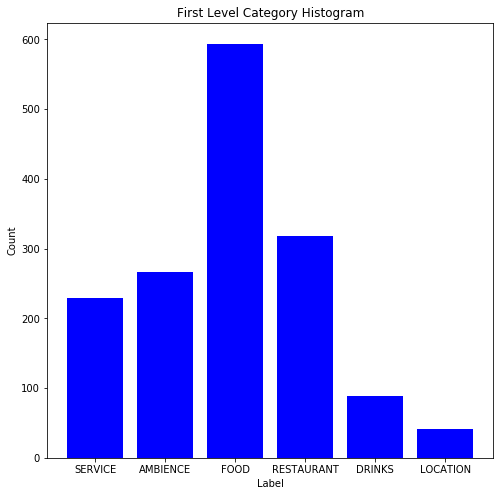

** SECOND LEVEL LABELS: ** 
 - SERVICE
GENERAL
 - AMBIENCE
GENERAL
 - FOOD
STYLE_OPTIONS
 - FOOD
QUALITY
 - RESTAURANT
PRICES
 - RESTAURANT
GENERAL
 - DRINKS
PRICES
 - DRINKS
QUALITY
 - FOOD
PRICES
 - LOCATION
GENERAL
 - DRINKS
STYLE_OPTIONS
 - RESTAURANT
MISCELLANEOUS  
 - ** Number of second level labels: ** 12

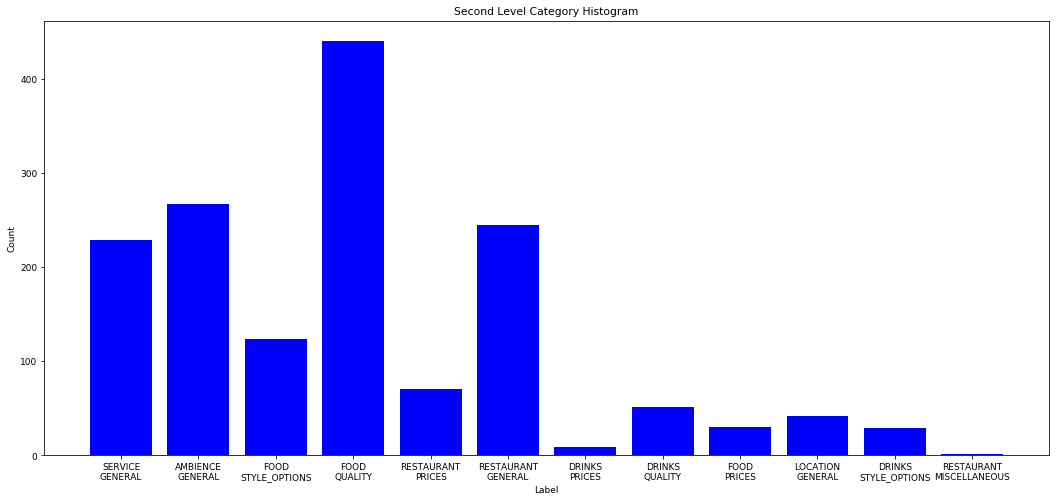

In [5]:
# VISUALIZE DATA STATISTICS
printmd("** Number of reviews: ** {}".format(len(first_level_labels)))

# FIRST LEVEL LABELS
matplotlib.rcParams.update({'font.size': 10})
first_level_label_counts = {}
for cur_labels in first_level_labels:
        for label in cur_labels:
            if label not in first_level_label_counts:
                first_level_label_counts[label] = 1
            else:
                first_level_label_counts[label] += 1
fig, ax = plt.subplots(figsize=(8, 8))
first_level_labels_set = [label for label, _ in first_level_label_counts.items()]
first_level_counts_set = [count for _, count in first_level_label_counts.items()]

# PRINT FIRST LEVEL LABELS STATS
printmd("** FIRST LEVEL LABELS: ** \n - {}  \n - ** Number of first level labels: ** {}"
        .format("\n - ".join(first_level_labels_set), len(first_level_labels_set)))



# PLOT FIRST LEVEL LABELS HISTOGRAM
plt.bar(first_level_labels_set, first_level_counts_set, width=0.80, color='b')
plt.title("First Level Category Histogram")
plt.ylabel("Count")
plt.xlabel("Label")
ax.set_xticks([l for l in first_level_labels_set])
ax.set_xticklabels(first_level_labels_set)
plt.show()

# SECOND LEVEL LABELS
matplotlib.rcParams.update({'font.size': 9})
second_level_label_counts = {}
for cur_labels1, cur_labels2 in zip(first_level_labels, second_level_labels):
        for label1, label2 in zip(cur_labels1, cur_labels2):
            label = label1 + "\n" + label2
            if label not in second_level_label_counts:
                second_level_label_counts[label] = 1
            else:
                second_level_label_counts[label] += 1
second_level_labels_set = [label for label, _ in second_level_label_counts.items()]
second_level_counts_set = [count for _, count in second_level_label_counts.items()]
                

# PRINT FIRST LEVEL LABELS STATS
printmd("** SECOND LEVEL LABELS: ** \n - {}  \n - ** Number of second level labels: ** {}"
        .format("\n - ".join(second_level_labels_set), len(second_level_labels_set)))


# PLOT SECOND LEVEL LABELS HISTOGRAM
fig, ax = plt.subplots(figsize=(18, 8))
plt.bar(second_level_labels_set, second_level_counts_set, width=0.80, color='b')

plt.title("Second Level Category Histogram")
plt.ylabel("Count")
plt.xlabel("Label")
ax.set_xticks([l for l in second_level_labels_set])
ax.set_xticklabels(second_level_labels_set)
plt.show()

In [6]:
# ALL LISTS BELOW SHOULD BE IN EQUAL LENGTH
assert len(raw_reviews) == len(preprocessed_reviews) == len(first_level_labels) == len(second_level_labels)

In [7]:
# PRINT AN EXAMPLE REVIEW
example_review_index = 105

printmd("**Raw review:** {}".format(raw_reviews[example_review_index]))
printmd("**Preprocessed review:** {}".format(preprocessed_reviews[example_review_index]))
printmd("**First level labels:**\n -  {}".format("\n - ".join(label for label in first_level_labels[example_review_index])))
printmd("**Second level labels:**\n - {}".format("\n - ".join(label1 + "/" + label2 for label1, label2
                                                              in zip(first_level_labels[example_review_index],
                                                                     second_level_labels[example_review_index]))))

**Raw review:** fiyatlar normal, servis cok yavaş, tuvaletler ise pis.

**Preprocessed review:** fiyat normal servis yavas tuvalet pis

**First level labels:**
 -  RESTAURANT
 - SERVICE
 - AMBIENCE

**Second level labels:**
 - RESTAURANT/PRICES
 - SERVICE/GENERAL
 - AMBIENCE/GENERAL

In [8]:
# CONSTRUCT TF-IDF SIMILARITY MATRIX
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(preprocessed_reviews)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
printmd("** TF-IDF REVIEW-TERM MATRIX **")
printmd("** Number of reviews: ** {}".format(X_train_tf.shape[0]))
printmd("** Number of terms: ** {}".format(X_train_tf.shape[1]))
printmd("** Shape of TF-IDF matrix: ** {}".format(X_train_tf.shape))
print()

tfidf_adjacency_matrix = 1 - pairwise_distances(X_train_tf, metric="cosine")
printmd("** TF-IDF ADJACENCY MATRIX **")
printmd("** Shape of adjacency the matrix: ** {}".format(tfidf_adjacency_matrix.shape))
print(tfidf_adjacency_matrix)

** TF-IDF REVIEW-TERM MATRIX **

** Number of reviews: ** 1228

** Number of terms: ** 1971

** Shape of TF-IDF matrix: ** (1228, 1971)

** TF-IDF ADJACENCY MATRIX **

** Shape of adjacency the matrix: ** (1228, 1228)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.03580438 ... 0.         0.         0.        ]
 [0.         0.03580438 1.         ... 0.05416269 0.         0.05983107]
 ...
 [0.         0.         0.05416269 ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.05983107 ... 0.         0.         1.        ]]


In [9]:
# DOC2VEC TRAINING
class LabeledLineSentence(object):
    def __init__(self, docs):
        self.docs = docs

    def __iter__(self):
        for uid, doc in enumerate(self.docs):
            yield TaggedDocument(doc.split(" "), ["RESTAURANT_REVIEW_{}".format(uid)])

pretrained_doc2vec_model_path = "resources/models/pretrained_doc2vec.model"
doc2vec_model_path = "resources/models/doc2vec.model"

# LOAD DOC2VEC MODEL IF EXISTS
if os.path.isfile(doc2vec_model_path):
    print("Loading already trained doc2vec model...")
    doc2vec_model = Doc2Vec.load(doc2vec_model_path)
    print("Done.")
else:
    # LOAD PRETRAINED DOC2VEC MODEL IF EXISTS
    if os.path.isfile(pretrained_doc2vec_model_path):
        print("Loading pre-trained doc2vec model...")
        doc2vec_model = Doc2Vec.load(doc2vec_model_path)
        print("Done")
    # CREATE NEW DOC2VEC MODEL OTHERWISE
    else:
        documents = LabeledLineSentence(preprocessed_reviews)
        doc2vec_model = Doc2Vec(size=50, window=8, min_count=5, workers=4,
                               alpha=0.025, min_alpha=0.025)
        print("building vocab...")
        doc2vec_model.build_vocab(documents)

    # RESUME TRAINING ON RESTAURANT DATASET 
    for epoch in range(5):
        print("Training... Epoch: {}".format(epoch))
        doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=1)
        doc2vec_model.alpha -= 0.004
        doc2vec_model.min_alpha = doc2vec_model.alpha
    print("Training completed. Saving model...")
    doc2vec_model.save(doc2vec_model_path)
    print("Done.")



Loading already trained doc2vec model...
Done.


In [10]:
# PLOT WORD VECTORS
def display_closestwords_tsnescatterplot(model, word, dim):
    
    arr = np.empty((0,dim), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_word(word, topn=10)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [ ]:
# MOST SIMILAR WORDS TO GIVEN WORD
word = input()
if word in doc2vec_model.wv:
    display_closestwords_tsnescatterplot(doc2vec_model, word, doc2vec_model.vector_size)
else:
    print("Not in vacobulary")

In [ ]:
# PLOT DOCUMENTS WITH TSNE
arr = np.empty((0, doc2vec_model.vector_size), dtype='f')
doc_labels = []
for i in range(50):
    selected_doc_index = random.randrange(len(raw_reviews))
    doc2vec_label = "RESTAURANT_REVIEW_{}".format(selected_doc_index)
    arr = np.append(arr, np.array([doc2vec_model.docvecs[doc2vec_label]]), axis=0)
    doc_labels.append(raw_reviews[selected_doc_index])
    
# find tsne coords for 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)
plt.figure(1, figsize=(20,20))
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)

for label, x, y in zip(doc_labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()

In [ ]:
review_vectors = []
for i, review in enumerate(raw_reviews):
    review_vectors.append(doc2vec_model.docvecs["RESTAURANT_REVIEW_{}".format(i)])
    

In [ ]:
# CONSTRUCT DOC2VEC SIMILARITY MATRIX
doc2vec_adjacency_matrix = 1 - pairwise_distances(review_vectors, metric="cosine")
printmd("** DOC2VEC ADJACENCY MATRIX **")
printmd("** Shape of adjacency the matrix: ** {}".format(doc2vec_adjacency_matrix.shape))
print(doc2vec_adjacency_matrix)

In [ ]:
# CREATE GRAPHS USING SIMILARITY MATRICES
def create_graph(adjacency_matrix, threshold=0.1, subsample_size=0):
    rows, cols = np.where(adjacency_matrix >= threshold)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    if subsample_size > 0:
        return gr.subgraph(list(range(subsample_size)))
    else:
        return gr

def get_meaningful_subgraph(G):
    G2 = G.subgraph(random.sample(list(range(0, len(G.nodes))), 100))
    degrees = G2.degree()
    to_keep = [k for k, v in degrees if v > 2]
    G3 = G2.subgraph(to_keep)
    return G3.subgraph(to_keep)

In [ ]:
# CREATE TF-IDF SIMILARITY GRAPH
tfidf_graph = create_graph(tfidf_adjacency_matrix, threshold=0.1)

In [ ]:
# PLOT SAMPLES IN TF-IDF SIMILARITY GRAPH
subsample_graph = get_meaningful_subgraph(tfidf_graph)
pos = nx.spring_layout(subsample_graph)
plt.figure(1, figsize=(20,10))
nx.draw(subsample_graph, pos=pos, node_size=200, labels={i: raw_reviews[i] for i in subsample_graph.nodes}, with_labels=True)
plt.show()

In [ ]:
# CREATE AND PLOT DOC2VEC SIMILARITY GRAPH
doc2vec_graph = create_graph(doc2vec_adjacency_matrix, threshold=0.3)

In [ ]:
# PLOT SAMPLES IN DOC2VEC SIMILARITY GRAPH
subsample_graph = get_meaningful_subgraph(doc2vec_graph)
pos = nx.spring_layout(subsample_graph)
plt.figure(1, figsize=(30,30))
nx.draw(subsample_graph, pos=pos, node_size=200, labels={i: raw_reviews[i] for i in subsample_graph.nodes}, with_labels=True)
plt.show()

In [ ]:
# PLOT DEGREE DISTRIBUTION OD TF_IDF AND DOC2VEC SIMILARITY GRAPHS WITH VARYING THRESHOLD VALUES
for i, adjacency_matrix in enumerate([tfidf_adjacency_matrix, doc2vec_adjacency_matrix]):
    if i == 0:
        printmd("** METHOD: TF-IDF ** \n")
    else:
        printmd("** METHOD: DOC2VEC ** \n")
    for threshold in [0.1, 0.2, 0.3, 0.4]:
        printmd("** Threshold: ** {}".format(threshold))
        graph = create_graph(adjacency_matrix, threshold=threshold)
        degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
        # print "Degree sequence", degree_sequence
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())

        fig, ax = plt.subplots(figsize=(30, 30))
        plt.bar(deg, cnt, width=0.80, color='b')

        plt.title("Degree Histogram")
        plt.ylabel("Count")
        plt.xlabel("Degree")
        ax.set_xticks([d + 0.4 for d in deg])
        ax.set_xticklabels(deg)

        # draw graph in inset
        plt.axes([0.4, 0.4, 0.5, 0.5])
        Gcc = sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True)[0]
        pos = nx.spring_layout(graph)
        plt.axis('off')
        nx.draw_networkx_nodes(graph, pos, node_size=20)
        nx.draw_networkx_edges(graph, pos, alpha=0.4)
        printmd("** Average degree count ** {}".format(np.mean(degree_sequence)))
        printmd("** Number of nodes without connection ** {}".format(len([x for x in degree_sequence if x <= 2])))
        plt.show()

In [ ]:
# CREATE PERSONALIZATION DICT FOR PERONILIZED PAGE RANK
def create_personalization_dic(label, num_seed=1, level="first"):
    personlization = {}
    num_found = 0
    for i, (cur_labels1, cur_labels2) in enumerate(zip(first_level_labels, second_level_labels)):
        personlization[i] = 0
        if num_found < num_seed:
            for label1, label2 in zip(cur_labels1, cur_labels2):
                if level == "first":
                    label_ = label1
                elif level == "second":
                    label_ = label1 + "\n" + label2
                else:
                    raise IOError("level parameter must be 'first' or 'second'!")
                if label == label_:
                    personlization[i] = 1
                    num_found += 1
                    #print("Seed Sentence_{}={}\nLabel={}".format(num_found, sentences[i], label))
                    break
    return personlization

In [ ]:
# CALCULATE RANDOM BASELINES USING STANDARD PAGE RANK ALGORITHM
results_dic = {}
for level in ["first", "second"]:
    precisions = []
    recalls = []
    fs = []
    threshold_for_labeling = 0.001
    if level == "first":
        label_set = first_level_labels_set
        label_counts = first_level_label_counts
    else:
        label_set = second_level_labels_set
        label_counts = second_level_label_counts
    for l in label_set:
        ppr1 = nx.pagerank(tfidf_graph, max_iter=100)
        predictions = [k for k, v in ppr1.items() if v >= threshold_for_labeling]
        if level == "first":
            corrects = sum([1 for prediction in predictions if l in  first_level_labels[prediction]])
        else:
            corrects = sum([1 for prediction in predictions 
                            if re.sub("^.*\n", r"", l) in second_level_labels[prediction]
                            and re.sub("\n.*$", r"", l) in first_level_labels[prediction]
                           ])
        
        relevant_count = label_counts[l]
        prediction_count = len(predictions)
        if prediction_count == 0:
            precision = 1
        else:
            precision = (corrects * 1.0) / prediction_count
        if relevant_count == 0:
            recall = 1
        else:
            recall = (corrects * 1.0) / relevant_count
        if precision == 0 and recall == 0:
            f = 0.0
        else:
            f = 2 * precision * recall / (precision + recall)
        precisions.append(precision)
        recalls.append(recall)
        fs.append(f)
    average_precision = sum(precisions) / len(precisions)
    average_recall = sum(recalls) / len(recalls)
    average_f = sum(fs) / len(fs)
    random_base_line_result = {"Average F1 Score": average_f,
                               "Average Precision": average_precision,
                               "Average Recall": average_recall,
                               "Labeling Threshold": threshold_for_labeling,
                               "Number of labeled reviews": "N/A"
                              }
    results_dic["Random baseline\n ({} level)".format(level)] = random_base_line_result
random_base_line_result_df = pd.DataFrame.from_dict(results_dic)
display(HTML(random_base_line_result_df.to_html()))

In [ ]:
# EVALUATE PERFORMANCE, EXPERIMENTS WITH VARYING THRESHOLDS and METHODS
thresholds_for_labeling = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.1]
num_seeds = [1, 5, 10, 20, 50]
for num_seed in num_seeds:
    for threshold_for_labeling in thresholds_for_labeling:
        for method in ["TF-IDF", "DOC2VEC"]:
            for level in ["first", "second"]:
                precisions = []
                recalls = []
                fs = []
                if level == "first":
                    label_set = first_level_labels_set
                    label_counts = first_level_label_counts
                else:
                    label_set = second_level_labels_set
                    label_counts = second_level_label_counts
                for l in label_set:
                    personalization = create_personalization_dic(l, num_seed=num_seed, level=level)
                    if method == "TF-IDF":
                        ppr1 = nx.pagerank(tfidf_graph, personalization=personalization, max_iter=100)
                    else:
                        ppr1 = nx.pagerank(doc2vec_graph, personalization=personalization, max_iter=100)
                    predictions = [k for k, v in ppr1.items() if v >= threshold_for_labeling]
                    if level == "first":
                        corrects = sum([1 for prediction in predictions if l in  first_level_labels[prediction]])
                    else:
                        corrects = sum([1 for prediction in predictions 
                                        if re.sub("^.*\n", r"", l) in second_level_labels[prediction]
                                        and re.sub("\n.*$", r"", l) in first_level_labels[prediction]
                                       ])

                    relevant_count = label_counts[l]
                    prediction_count = len(predictions)
                    if prediction_count == 0:
                        precision = 1
                    else:
                        precision = (corrects * 1.0) / prediction_count
                    if relevant_count == 0:
                        recall = 1
                    else:
                        recall = (corrects * 1.0) / relevant_count
                    if precision == 0 and recall == 0:
                        f = 0.0
                    else:
                        f = 2 * precision * recall / (precision + recall)
                    precisions.append(precision)
                    recalls.append(recall)
                    fs.append(f)
                average_precision = sum(precisions) / len(precisions)
                average_recall = sum(recalls) / len(recalls)
                average_f = sum(fs) / len(fs)
                result = {"Average F1 Score": average_f,
                          "Average Precision": average_precision,
                          "Average Recall": average_recall,
                          "Labeling Threshold": threshold_for_labeling,
                          "Number of labeled reviews": num_seed
                         }
                results_dic["{}\n [Labeling Threshold={},\n Number of labeled reviews={}] ({} level performance)"
                            .format(method, threshold_for_labeling, num_seed, level)] = result
result_df = pd.DataFrame.from_dict(results_dic)
result_df.to_excel("Results.xlsx")
display(HTML(result_df.to_html()))

In [ ]:
# SELECT BEST CONFIGURATION
best_tfidf_threshold = 0.0
best_doc2vec_threshold = 0.0
max_acc = 0.0
best_conf = ""
for conf_name, conf_dic in results_dic.items():
    if conf_dic["Average F1 Score"] > max_acc:
        max_acc = conf_dic["Average F1 Score"]
        best_conf = conf_name
        if conf_name.startswith("TF-IDF"):
            best_tfidf_threshold = conf_dic["Labeling Threshold"]
        else:
            best_doc2vec_threshold = conf_dic["Labeling Threshold"]
printmd("** Best Configuration: ** {}".format(best_conf))
printmd("** Best F1 Score: ** {}".format(max_acc))

In [ ]:
# Labeling Threshold - F Score plot 
doc2vec_threshold_first_level = []
doc2vec_f_scores_first_level = []
doc2vec_threshold_second_level = []
doc2vec_f_scores_second_level = []
tf_idf_threshold_first_level = []
tf_idf_f_scores_first_level = []
tf_idf_threshold_second_level = []
tf_idf_f_scores_second_level = []
for conf_name, conf_dic in results_dic.items():
    if conf_name.startswith("TF-IDF") and conf_dic["Number of labeled reviews"] == 50:
        if "first" in conf_name:
            tf_idf_threshold_first_level.append(conf_dic["Labeling Threshold"])
            tf_idf_f_scores_first_level.append(conf_dic["Average F1 Score"])
        else:
            tf_idf_threshold_second_level.append(conf_dic["Labeling Threshold"])
            tf_idf_f_scores_second_level.append(conf_dic["Average F1 Score"])
    elif conf_dic["Number of labeled reviews"] == 50:
        if "first" in conf_name:
            doc2vec_threshold_first_level.append(conf_dic["Labeling Threshold"])
            doc2vec_f_scores_first_level.append(conf_dic["Average F1 Score"])
        else:
            doc2vec_threshold_second_level.append(conf_dic["Labeling Threshold"])
            doc2vec_f_scores_second_level.append(conf_dic["Average F1 Score"])
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(20, 10))
plt.title("Labeling threshold vs Performance")
plt.ylabel("F1 Score")
plt.xlabel("Labeling threshold")
plt.plot(doc2vec_threshold_first_level, doc2vec_f_scores_first_level)
plt.plot(doc2vec_threshold_second_level, doc2vec_f_scores_second_level)
plt.plot(tf_idf_threshold_first_level, tf_idf_f_scores_first_level)
plt.plot(tf_idf_threshold_second_level, tf_idf_f_scores_second_level)
plt.yscale('linear')
plt.grid(True)
plt.legend(['Doc2Vec first level performance', 
            'Doc2Vec second level performance', 
            'TF-IDF first level performance', 
            'TF-IDF second level performance'], loc='upper left')

In [ ]:
# Number of labeled reviews - F Score plot 
doc2vec_num_seed_first_level = []
doc2vec_f_scores_first_level = []
doc2vec_num_seed_second_level = []
doc2vec_f_scores_second_level = []
tf_idf_num_seed_first_level = []
tf_idf_f_scores_first_level = []
tf_idf_num_seed_second_level = []
tf_idf_f_scores_second_level = []
for conf_name, conf_dic in results_dic.items():
    if conf_name.startswith("TF-IDF") and conf_dic["Labeling Threshold"] == best_tfidf_threshold:
        if "first" in conf_name:
            tf_idf_num_seed_first_level.append(conf_dic["Number of labeled reviews"])
            tf_idf_f_scores_first_level.append(conf_dic["Average F1 Score"])
        else:
            tf_idf_num_seed_second_level.append(conf_dic["Number of labeled reviews"])
            tf_idf_f_scores_second_level.append(conf_dic["Average F1 Score"])
    elif conf_dic["Labeling Threshold"] == best_doc2vec_threshold:
        if "first" in conf_name:
            doc2vec_num_seed_first_level.append(conf_dic["Number of labeled reviews"])
            doc2vec_f_scores_first_level.append(conf_dic["Average F1 Score"])
        else:
            doc2vec_num_seed_second_level.append(conf_dic["Number of labeled reviews"])
            doc2vec_f_scores_second_level.append(conf_dic["Average F1 Score"])
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(20, 10))
plt.title("Number of Labeled Reviews vs Performance")
plt.ylabel("F1 Score")
plt.xlabel("Number of labeled reviews")
plt.plot(doc2vec_num_seed_first_level, doc2vec_f_scores_first_level)
plt.plot(doc2vec_num_seed_second_level, doc2vec_f_scores_second_level)
plt.plot(tf_idf_num_seed_first_level, tf_idf_f_scores_first_level)
plt.plot(tf_idf_num_seed_second_level, tf_idf_f_scores_second_level)
plt.yscale('linear')
plt.grid(True)
plt.legend(['Doc2Vec first level performance', 
            'Doc2Vec second level performance', 
            'TF-IDF first level performance', 
            'TF-IDF second level performance'], loc='upper left')

In [ ]:
# PREDICTIONS WITH BEST CONFIGURATION
num_seed = 50
method = "DOC2VEC"
threshold_for_labeling = best_doc2vec_threshold
level = "second"

model_outputs = []
if level == "first":
    label_set = first_level_labels_set
else:
    label_set = second_level_labels_set
for raw_text, cur_labels1, cur_labels2 in zip(raw_reviews, first_level_labels, second_level_labels):
    if level == "first":
        model_outputs.append({"Text": raw_text, 
                              "Predicted labels": "", 
                              "Gold labels": " ".join(cur_labels1)})
    else:
        model_outputs.append({"Text": raw_text, 
                              "Predicted labels": "", 
                              "Gold labels": " ".join(
                                  [cur_label1 + "/" + cur_label2 
                                   for cur_label1, cur_label2 in zip(cur_labels1, cur_labels2)]
                              )
                             })

for l in label_set:
    personalization = create_personalization_dic(l, num_seed=num_seed, level=level)
    if method == "TF-IDF":
        ppr1 = nx.pagerank(tfidf_graph, personalization=personalization, max_iter=100)
    else:
        ppr1 = nx.pagerank(doc2vec_graph, personalization=personalization, max_iter=100)
    predictions = [k for k, v in ppr1.items() if v >= threshold_for_labeling]
    for prediction in predictions:
        model_outputs[prediction]["Predicted labels"] = model_outputs[prediction]["Predicted labels"] + " " + l.replace("\n","/")
        model_outputs[prediction]["Predicted labels"] = model_outputs[prediction]["Predicted labels"].strip()

model_predictions_df = pd.DataFrame.from_dict(model_outputs)
model_predictions_df.to_excel("Model Predictions.xlsx")
display(HTML(model_predictions_df.to_html()))